In [2]:
import shap
import torch
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

/Users/aliu/courses/info259/finalproj/nlp23-detecting-ai/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load ChatGPT detector model 

In [1]:
# ! wget https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt

--2023-04-26 23:26:47--  https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-base.pt
Resolving openaipublic.azureedge.net (openaipublic.azureedge.net)... 2620:1ec:4e:1::69, 2620:1ec:4f:1::69, 13.107.237.69, ...
Connecting to openaipublic.azureedge.net (openaipublic.azureedge.net)|2620:1ec:4e:1::69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 501001061 (478M) [application/octet-stream]
Saving to: ‘detector-base.pt’

detector-base.pt    100%[===================>] 477.79M  22.3MB/s    in 21s     

2023-04-26 23:27:09 (22.4 MB/s) - ‘detector-base.pt’ saved [501001061/501001061]



In [ ]:
model = torch.load('detector-base.pt') 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("roberta-base-openai-detector")
if device.type == "cpu":
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector"
    )
else:
    model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base-openai-detector", device_map="auto"
    )

pred = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device, return_all_scores=True)



Using device: cpu


Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
`return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.


[[{'label': 'Fake', 'score': 0.00016875859000720084},
  {'label': 'Real', 'score': 0.9998311996459961}]]

# Set up SHAP

In [4]:
explainer = shap.Explainer(pred)

In [89]:
# Test
test_case = 'Pot sellers had no incentive not to sell to minors when it was illegal to sell pot to everyone . Now that selling pot to adults is legal , they have a legal incentive not to sell it to children .'
pred(test_case)

[[{'label': 'Fake', 'score': 0.00146488135214895},
  {'label': 'Real', 'score': 0.99853515625}]]

In [90]:
shap_values = explainer([test_case]) # must be passed as an iterable
shap.plots.text(shap_values)

Partition explainer: 2it [02:00, 120.67s/it]              


In [12]:
shap_values.hierarchical_values.shape

(1, 281, 2)

In [28]:
shap_values.data[0].shape

(141,)

In [25]:
shap_values.values.shape 

(1, 141, 2)

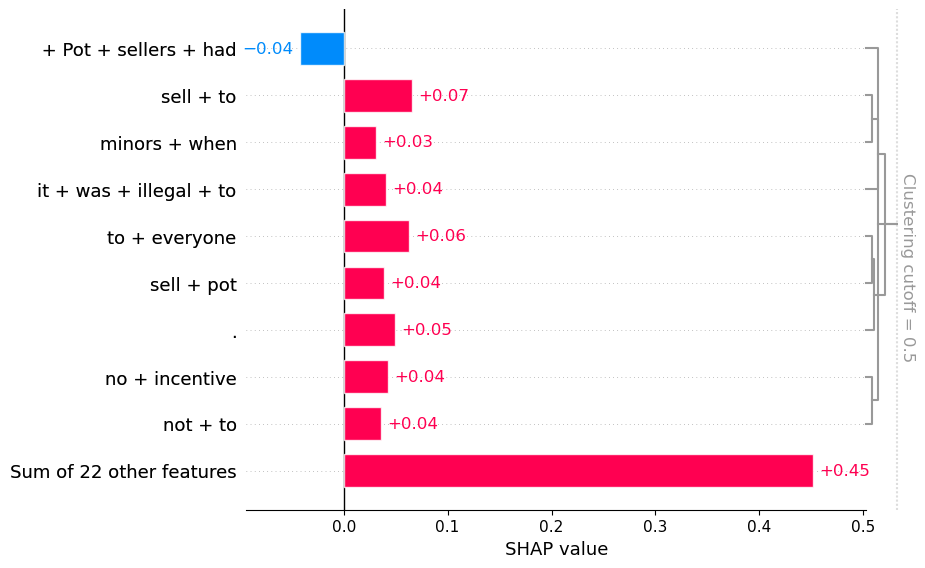

In [91]:
shap.plots.bar(shap_values[0,:,"Real"], order=shap.Explanation.argsort)

In [62]:
df = pd.read_csv("data/misclassified.csv")
subset_df = df.iloc[:153].copy().sort_values(by="pred_probability")

In [82]:
bottom_10 = subset_df.head(10).copy()
top_10 = subset_df.tail(10).copy()


In [83]:
top10_shap_values = explainer(top_10["responses"])

Partition explainer: 11it [22:33, 135.30s/it]                        


In [84]:
bot10_shap_values = explainer(bottom_10["responses"])

Partition explainer: 11it [16:37, 99.79s/it]                         


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


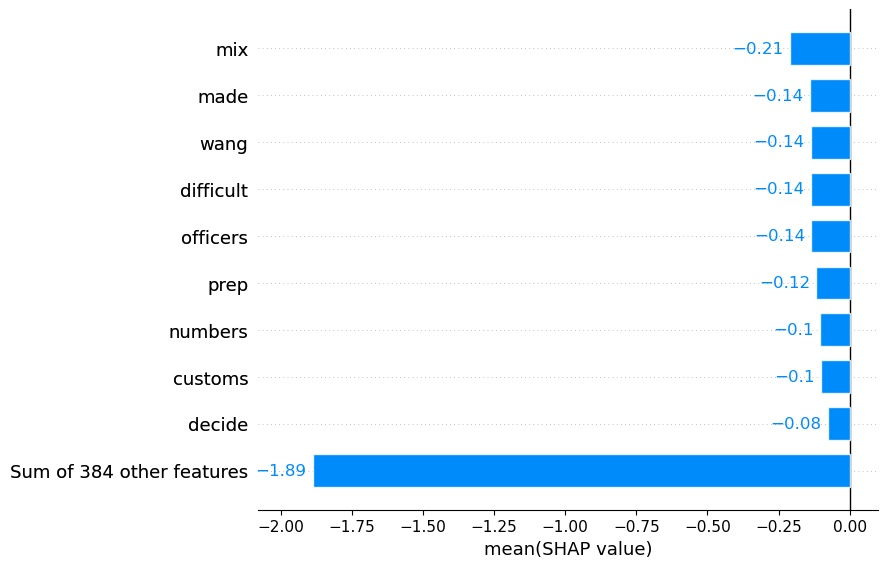

In [85]:
shap.plots.bar(top10_shap_values[:,:,"Fake"].mean(0), order=shap.Explanation.argsort)

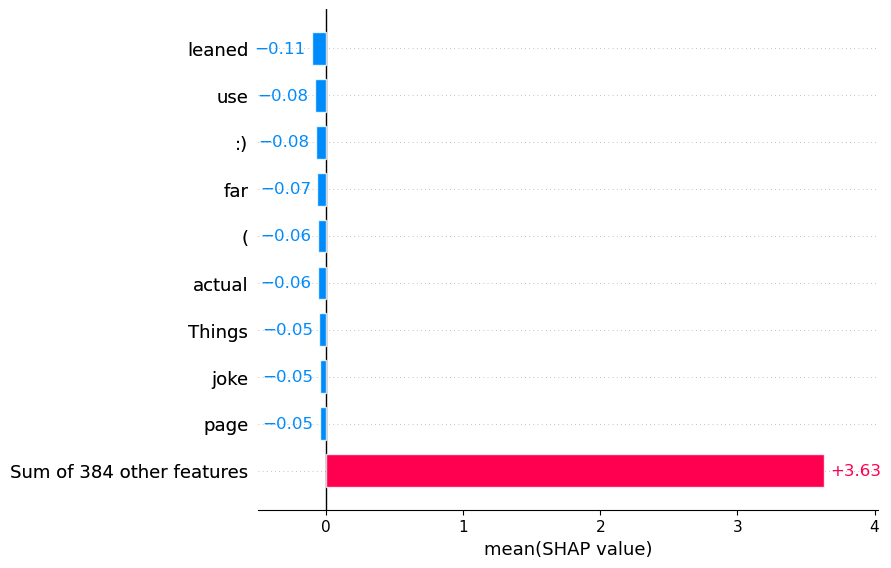

In [86]:
shap.plots.bar(top10_shap_values[:,:,"Real"].mean(0), order=shap.Explanation.argsort)

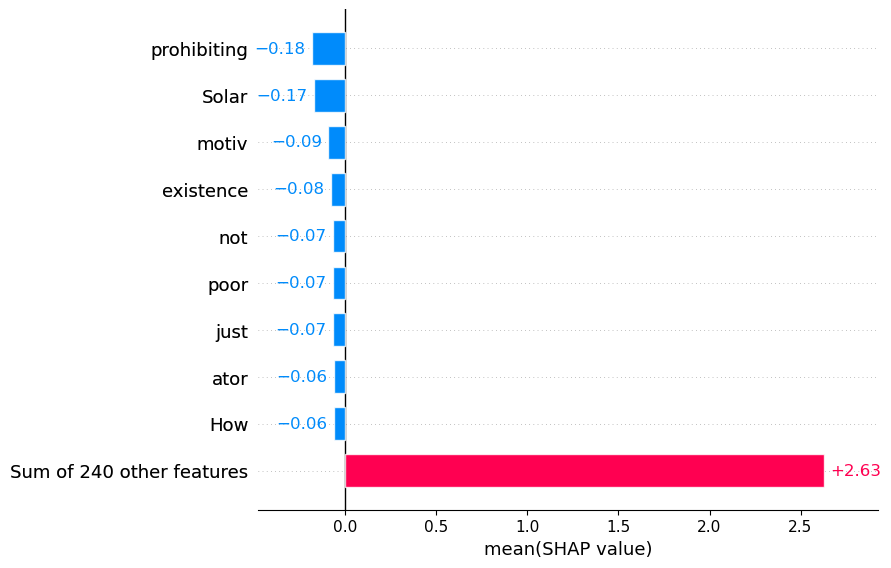

In [87]:
shap.plots.bar(bot10_shap_values[:,:,"Real"].mean(0), order=shap.Explanation.argsort)

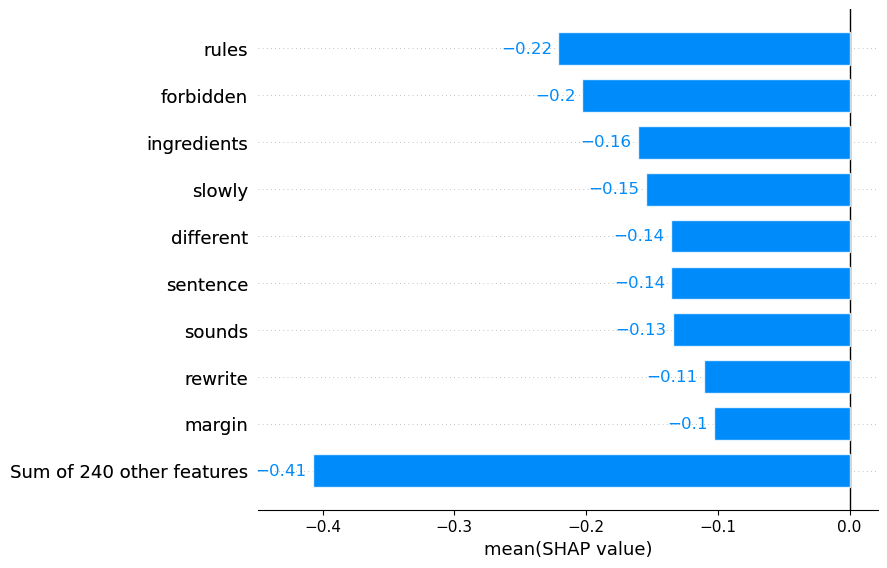

In [88]:
shap.plots.bar(bot10_shap_values[:,:,"Fake"].mean(0), order=shap.Explanation.argsort)

In [64]:
if input_ids.shape[1] > 512: # Error handling for max input size 
    input_ids.resize_(input_ids.shape[0], 512)
    oversized_inputs.append(gpt_response)
bottom_10

,Unnamed: 0,id,question,responses,actual_label,pred_label,pred_probability,sensi_cont,emoji_char,spchar_noeng,incomp_sent,named_entity,profanity,rhetoric,subjectivity,coherence,type1,type2,short_text
86,86,2530,Would my dead body decompose if sent into spac...,Solar radiation would likely pick you apart sl...,Real,Fake,0.502060,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
144,144,3805,why diffrent alcohols effect me . I can drink ...,* different * affect * just rewrite that sentence,Real,Fake,0.506464,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,1
69,69,1990,What happens to someone in a wheelchair when t...,How do the other prisoners treat them ?,Real,Fake,0.506785,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,1
72,72,2125,Why does store bought orange juice ( e.g. Trop...,"pasteurization , poor quality fruit , and unme...",Real,Fake,0.508209,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,1
64,64,1874,How does my ISP ( Suddenlink ) know when I 've...,They recieved a letter from the studio that cl...,Real,Fake,0.509648,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1
94,94,2797,Why are current protesters and anti government...,It sounds scarier . Fear is a motivator and us...,Real,Fake,0.509856,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,1,1
134,134,3634,Why is there existence ? Why is there anything...,Because in nothingness are no rules prohibitin...,Real,Fake,0.510247,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,1
37,37,945,Why do fast food meals include fries and soft ...,because people love fries and soft drinks . th...,Real,Fake,0.513258,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0,1,1
61,61,1847,Why does irish music sound like pirate music ?...,Because composers for pirate films used Irish ...,Fake,Real,0.513766,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0,1
114,114,3203,Why is n't it considered corruption when polit...,Short answer : it depends on the country . I t...,Fake,Real,0.514437,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1,0,1


In [58]:
sample_shap_values = explainer(subset_df["responses"])

Partition explainer:  75%|███████▍  | 114/153 [3:28:14<1:11:52, 110.57s/it]


RuntimeError: The expanded size of the tensor (846) must match the existing size (514) at non-singleton dimension 1.  Target sizes: [1, 846].  Tensor sizes: [1, 514]